## 1D PIC (evolution_version) thermal heating

Here we compute the 1D version of PIC. 
The distribution we use corresponds to a particles in a thermal bath with a given temperature.
The distribution is:

$$
f(x,v) = \frac{N}{L} \sqrt{\frac{\theta}{2\pi}} e^{-\frac{v^2}{2\theta}}
$$


In [ ]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
import Pkg; Pkg.add("FileIO")
using FileIO
using Distributions

Helper functions are defined in this file.

In [ ]:
include("aux_functions.jl")

In [3]:
run_name = "long_"
order = 1
const L = 5
#N = 80000
const N = 20000
const J = 50
exp_Theta = 1
exp_t = 5
θ = 10.0^(-exp_Theta)
t = 0.0
t_f = 10.0^(exp_t)
M = 1_000_001
M_g = 1000 + 1 #number of outputs, starting from the initial data
dt = t_f / (M-1)
t_i = 0.0
#M = convert(Int64,t_f/dt)
#M=1
const κ = 2π/L # for Fourier Transform
dx = L/J
x = [dx*(i-1) for i in 1:J] ;
p = (L, N, J, κ, dx, order)

animation = false

run_name = run_name * "t$(convert(Int,t_f))_L$(L)_N2_5_J$(J)_M$(M)_o$(order)_T$(exp_Theta)"


false

We have some extra quantities that are proper of the plasma:

The plasma frequency and the Debye temperature:

The plasma frequency is adjusted so that it is unit in with respect to the time units 
taken, space it taken so that the speed of light is one. 
$$
\omega_p^2 = 1
$$

This implies that the background density is $N/L$

In the paper they say the temperature is set to $\theta_D = dx^2$. 

This I don't understand yet.

$$
\lambda_D^2 := \frac{\epsilon_0 \theta_D L}{e^2 N_e} = \frac{\theta_D L}{N_e}
$$

If we set $\lambda_D = dx$ then, 

$$
\theta_D = \frac{N_e dx^2}{L} = \frac{N_e L}{J^2}
$$

For N = 20000, L = 5, J = 50, $\theta_D = 


We build the initial data:

In [ ]:
E = zeros(J)
ϕ = zeros(J)
n = zeros(J) #charge density
S = zeros(J) #carge current
du = zeros(2*N+J); # contains r, v and E


In [ ]:
par_dis = load("Initial_Distributions/par_dis_L5_N2_5_theta001.jld2", "par_dis");

@assert length(par_dis) ÷ 2 == N

With the particle distribution we construct the initial data for the electric field. For that first we compute de density, using different types of particles (order).

In [ ]:
@time get_density!(par_dis, n, p)
n0 = N/L
#get_ϕ!(ϕ, -n/n0 .+ 1., κ) # chenge the sign here to make it consistent with charge conservation and the time derivative of E
@time get_ϕ!(ϕ, n/n0 .- 1., κ)
@time get_E_from_ϕ!(ϕ,E,dx)
u = [par_dis;E];
length(u)

### What follows are characterizations of the initial data properties.

In [ ]:
@time get_current!(u, S, p)

@time Coordinate_test(u[1:N],L)

println("n_total = $(sum(n .- n0))")
println("v_total = $(sum(u[N+1:2N]))")
println("E_total = $(sum(E))")

println("S_total = $(sum(S))")

Compute the initial density, potential and electric field.

In [ ]:
plot(layout=(2,2))
plot!(subplot=1,x,n/n0, title = "density", legend = :false)
plot!(subplot=2,x,ϕ, title = "potential", legend = :false)
plot!(subplot=3,x,E, title = "Electric Field", legend = :false)
plot!(subplot=4,x,S, title = "Current", legend = :false)

Check the histograms for the initial positions and velocities.

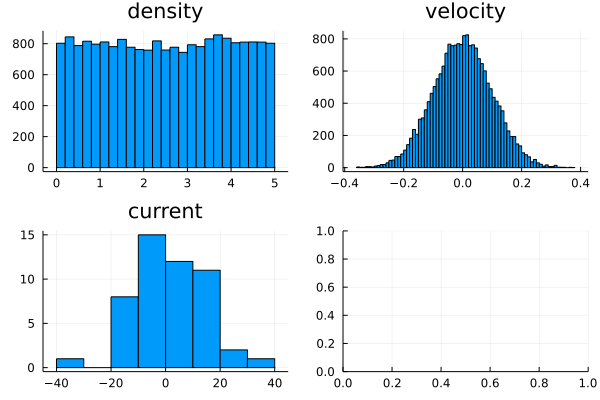

In [197]:
plot(layout=(2,2))
histogram!(subplot=1,u[1:N], title = "density", legend = :false)
histogram!(subplot=2,u[N+1:2*N], title = "velocity", legend = :false)

histogram!(subplot=3,S, title = "current", legend = :false)

## TIME Evolution: 

Now we make the time evolution:

1. we define parameters and vectors where to upload data to study the time evolution: Kinetic Energy, Electric field Energy, Total Electric field, total velocity (momentum), total density, total charge current.

2. we save a vector with the particle phase space, this can be a lot of memory!

In [7]:
p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current!, Interpolate_2) ;


Energy_K = zeros(M_g)
Energy_E = zeros(M_g)
E_T = zeros(M_g)
v_T = zeros(M_g)
D_T = zeros(M_g)
S_T = zeros(M_g)
T = zeros(M_g)
if animation
par = zeros(M_g,2N)
end
Energy_K[1], Energy_E[1]  = get_energy(u,(L, N, J))
E_T[1] = sum(u[2N+1:end])
v_T[1] = sum(u[N+1:2N])
get_density!(u, n, p)
get_current!(u, S, p)
D_T[1] = sum(n)/n0/J - 1
S_T[1] = sum(S)/n0/J
T[1] = var(u[N+1:2N])
if animation
par[1,:] = u[1:2N]
end



t = 0.0
j = 1



1

In [8]:

for k in 2:(M+1)
  RK4_Step!(RHSC,u,t,dt,p_RHSC)
  u = [make_periodic!(u[1:N],L); u[N+1:end]]
  #filter_constant!(u[2N+1:end])
  t = t + dt
  if (k-1) % (M÷(M_g-1)) == 0
    j = j+1
    #scatter(plt, u[1:N], u[N+1:2*N])
    Energy_K[j], Energy_E[j] = get_energy(u,(L, N, J))
    E_T[j] = sum(u[2N+1:end])
    v_T[j] = sum(u[N+1:2N])
    get_density!(u, n, p)
    get_current!(u, S, p)
    D_T[j] = sum(n)/n0/J - 1
    S_T[j] = sum(S)/n0/J
    T[j] = var(u[N+1:2N])
    println("j = $j , t = $t, k = $k")
    if animation
    par[j,:] = u[1:2N]
    end
  end
end

j = 2 , t = 99.9999999999986, k = 1001
j = 3 , t = 199.99999999999292, k = 2001
j = 4 , t = 299.9999999999997, k = 3001
j = 5 , t = 400.00000000002245, k = 4001
j = 6 , t = 500.0000000000452, k = 5001
j = 7 , t = 600.0000000000679, k = 6001
j = 8 , t = 700.0000000000906, k = 7001
j = 9 , t = 800.0000000001133, k = 8001
j = 10 , t = 900.0000000001361, k = 9001
j = 11 , t = 1000.0000000001588, k = 10001
j = 12 , t = 1100.000000000095, k = 11001
j = 13 , t = 1200.000000000004, k = 12001
j = 14 , t = 1299.9999999999131, k = 13001
j = 15 , t = 1399.9999999998222, k = 14001
j = 16 , t = 1499.9999999997312, k = 15001
j = 17 , t = 1599.9999999996403, k = 16001
j = 18 , t = 1699.9999999995493, k = 17001
j = 19 , t = 1799.9999999994584, k = 18001
j = 20 , t = 1899.9999999993674, k = 19001
j = 21 , t = 1999.9999999992765, k = 20001
j = 22 , t = 2099.9999999991855, k = 21001
j = 23 , t = 2199.9999999990946, k = 22001
j = 24 , t = 2299.9999999990036, k = 23001
j = 25 , t = 2399.9999999989127, k = 2

j = 238 , t = 23699.99999993561, k = 237001
j = 239 , t = 23799.999999934156, k = 238001
j = 240 , t = 23899.9999999327, k = 239001
j = 241 , t = 23999.999999931246, k = 240001
j = 242 , t = 24099.99999992979, k = 241001
j = 243 , t = 24199.999999928335, k = 242001
j = 244 , t = 24299.99999992688, k = 243001
j = 245 , t = 24399.999999925425, k = 244001
j = 246 , t = 24499.99999992397, k = 245001
j = 247 , t = 24599.999999922515, k = 246001
j = 248 , t = 24699.99999992106, k = 247001
j = 249 , t = 24799.999999919604, k = 248001
j = 250 , t = 24899.99999991815, k = 249001
j = 251 , t = 24999.999999916694, k = 250001
j = 252 , t = 25099.99999991524, k = 251001
j = 253 , t = 25199.999999913784, k = 252001
j = 254 , t = 25299.99999991233, k = 253001
j = 255 , t = 25399.999999910873, k = 254001
j = 256 , t = 25499.999999909418, k = 255001
j = 257 , t = 25599.999999907963, k = 256001
j = 258 , t = 25699.999999906508, k = 257001
j = 259 , t = 25799.999999905052, k = 258001
j = 260 , t = 25899.

j = 469 , t = 46799.999999599466, k = 468001
j = 470 , t = 46899.99999959801, k = 469001
j = 471 , t = 46999.999999596555, k = 470001
j = 472 , t = 47099.9999995951, k = 471001
j = 473 , t = 47199.999999593645, k = 472001
j = 474 , t = 47299.99999959219, k = 473001
j = 475 , t = 47399.999999590735, k = 474001
j = 476 , t = 47499.99999958928, k = 475001
j = 477 , t = 47599.999999587824, k = 476001
j = 478 , t = 47699.99999958637, k = 477001
j = 479 , t = 47799.999999584914, k = 478001
j = 480 , t = 47899.99999958346, k = 479001
j = 481 , t = 47999.999999582, k = 480001
j = 482 , t = 48099.99999958055, k = 481001
j = 483 , t = 48199.99999957909, k = 482001
j = 484 , t = 48299.99999957764, k = 483001
j = 485 , t = 48399.99999957618, k = 484001
j = 486 , t = 48499.99999957473, k = 485001
j = 487 , t = 48599.99999957327, k = 486001
j = 488 , t = 48699.99999957182, k = 487001
j = 489 , t = 48799.99999957036, k = 488001
j = 490 , t = 48899.99999956891, k = 489001
j = 491 , t = 48999.999999567

j = 702 , t = 70099.99999959247, k = 701001
j = 703 , t = 70199.9999995983, k = 702001
j = 704 , t = 70299.99999960412, k = 703001
j = 705 , t = 70399.99999960994, k = 704001
j = 706 , t = 70499.99999961576, k = 705001
j = 707 , t = 70599.99999962158, k = 706001
j = 708 , t = 70699.9999996274, k = 707001
j = 709 , t = 70799.99999963322, k = 708001
j = 710 , t = 70899.99999963904, k = 709001
j = 711 , t = 70999.99999964486, k = 710001
j = 712 , t = 71099.99999965068, k = 711001
j = 713 , t = 71199.9999996565, k = 712001
j = 714 , t = 71299.99999966232, k = 713001
j = 715 , t = 71399.99999966814, k = 714001
j = 716 , t = 71499.99999967396, k = 715001
j = 717 , t = 71599.99999967979, k = 716001
j = 718 , t = 71699.9999996856, k = 717001
j = 719 , t = 71799.99999969143, k = 718001
j = 720 , t = 71899.99999969725, k = 719001
j = 721 , t = 71999.99999970307, k = 720001
j = 722 , t = 72099.99999970889, k = 721001
j = 723 , t = 72199.99999971471, k = 722001
j = 724 , t = 72299.99999972053, k =

j = 936 , t = 93500.00000095453, k = 935001
j = 937 , t = 93600.00000096035, k = 936001
j = 938 , t = 93700.00000096617, k = 937001
j = 939 , t = 93800.000000972, k = 938001
j = 940 , t = 93900.00000097782, k = 939001
j = 941 , t = 94000.00000098364, k = 940001
j = 942 , t = 94100.00000098946, k = 941001
j = 943 , t = 94200.00000099528, k = 942001
j = 944 , t = 94300.0000010011, k = 943001
j = 945 , t = 94400.00000100692, k = 944001
j = 946 , t = 94500.00000101274, k = 945001
j = 947 , t = 94600.00000101856, k = 946001
j = 948 , t = 94700.00000102438, k = 947001
j = 949 , t = 94800.0000010302, k = 948001
j = 950 , t = 94900.00000103602, k = 949001
j = 951 , t = 95000.00000104184, k = 950001
j = 952 , t = 95100.00000104767, k = 951001
j = 953 , t = 95200.00000105349, k = 952001
j = 954 , t = 95300.0000010593, k = 953001
j = 955 , t = 95400.00000106513, k = 954001
j = 956 , t = 95500.00000107095, k = 955001
j = 957 , t = 95600.00000107677, k = 956001
j = 958 , t = 95700.00000108259, k = 

@time results:

M=401
t=40
N = 20000
J = 50
L = 5

const order 5 interpolation_2:  33.584136 seconds (51.33 k allocations: 2.456 GiB, 0.69% gc time)

const order 5 interpolation_1:  30. sec

order 5 interpolation_2: 31.499545 seconds (51.33 k allocations: 2.456 GiB, 0.86% gc time) 

order 1 interpolation_2: 7.579297 seconds (51.33 k allocations: 2.456 GiB, 3.12% gc time)

order 3 interpolation_2: 11.414688 seconds (51.33 k allocations: 2.456 GiB, 1.99% gc time)

order 5 interpolation_2: 32.217357 seconds (51.33 k allocations: 2.456 GiB, 0.70% gc time)

order 5 interpolation_2 no-filter-const: 33.524110 seconds (18.85 k allocations: 2.454 GiB, 0.76% gc time)

There are other time results in current_density_check.ipynb

## Studying the solutions: 

### Energy:

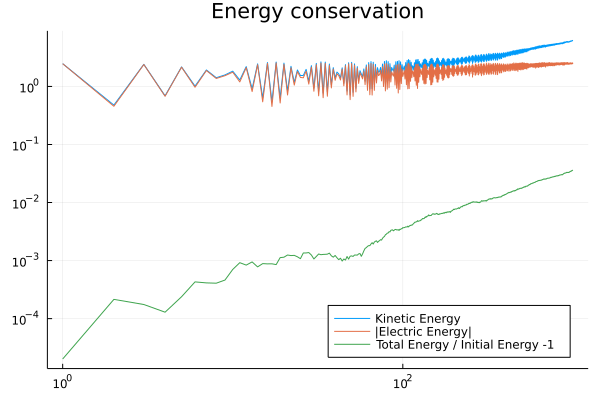

In [37]:
plot(abs.(Energy_K[2:end] .- Energy_K[1]), title = "Energy conservation", label = "Kinetic Energy"
#, legend = :outertopright
, legend = :bottomright)
plot!(abs.(Energy_E[2:end] .- Energy_E[1]), label = "|Electric Energy|")
plot!(abs.(Energy_K[2:end]  + Energy_E[2:end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1]+Energy_E[1]) , yscale=:log10, xscale=:log10, label = "Total Energy / Initial Energy -1 ")
png("$run_name * energy_conservation")

In [10]:
abs.(Energy_K[end]  + Energy_E[end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1]+Energy_E[1])

0.03600948347614017

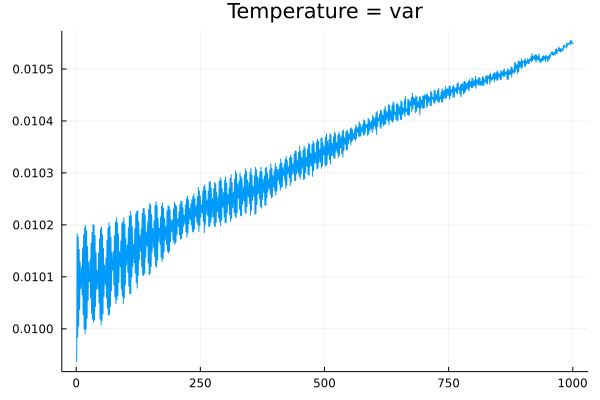

In [29]:
plot(T, label= "θ", title = "Temperature = var", legend = false)
#png("$run_name * temperature")

In [17]:
T[end]

0.01011941223785086

In [17]:
run_name

"long_t100000_L5_N2_5_J50_M1000001_o1_T1"

| time | order | energy | theta |
|------|-------|--------|-------|
|  40  |  1    | 7.4e-7 | 0.009978|
|  40  |  3    | 7.9e-8 | 0.009979 |
|  40  |  5    | 1.1e-7 | 0.009979 |
|  4000|  1    | 7.6e-5 | 0.009978 |
|  4000|  3    | 7.2e-6 | 0.010086 |
|  4000|  5    | 1.0e-5 | 0.010031 |
|  4e6 |  1    | 0.0360 | 0.010119 |


## Total Quantities

In [18]:
plot(layout=(2,2))
plot!(subplot=1,E_T,title="Total Electric Field")
plot!(subplot=2,v_T./N, title="Total velocity")
plot!(subplot=3,D_T,title = "Total density")
plot!(subplot=4,S_T,title = "Total Current")
png("$run_name * totals")

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294


In [22]:
E_F = zeros(J)
ϕ_F = zeros(J)
n_F = zeros(J)
get_density!(u, n_F, p)
n0 = N/L
get_ϕ!(ϕ_F, n_F/n0 .+ 1, κ)
#get_ϕ!(ϕ_F, n_F .- n0, κ)
get_E_from_ϕ!(ϕ_F,E_F,dx)
plot(x,u[2N+1:end], label = "dynamical", title="Electric Field with order = $(order)")
plot!(x,E_F,label="from constraint", ls=:dash)
#t_f = 40
#png("$run_name * E")

In [23]:
println("averaged total E field = $(sum(E_F))")
println("E_total = $(sum(u[2N+1:end])/J)")
println("Total velocity = $(sum(u[N+1:2N])/N)")
println("Total Charge = $(sum(n_F .- n0))")
println("Final Energy = $(get_energy(u,(L, N, J)))")
get_current!(u, S, p)
println("Total_current = $(sum(S)/J)")

averaged total E field = 5.204170427930421e-18
E_total = -0.0010067690877645938
Total velocity = -0.0008386991773406967
Total Charge = 1.5006662579253316e-11
Final Energy = (105.47561415685391, 0.22335405411108233)
Total_current = -3.354796709362788


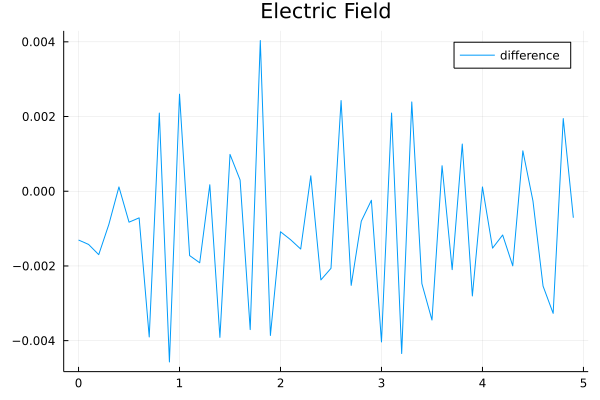

In [25]:
plot(x,u[2N+1:end]-E_F, label = "difference", title="Electric Field")
#png("$run_name * electric_diff")

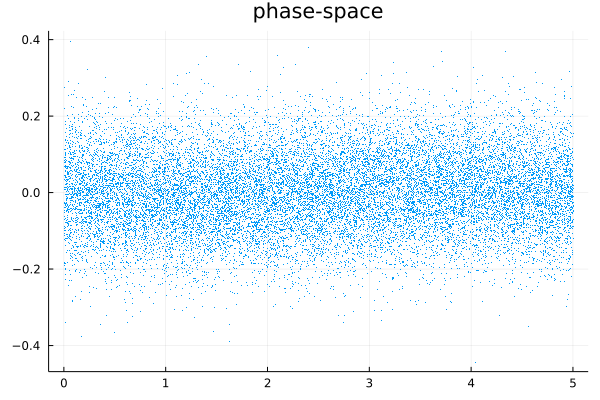

In [207]:
scatter(u[1:N],u[N+1:2N]
#, thickness_scaling = 0.3
, markersize = 0.3
, title = "phase-space", legend =:false)
#png("run_name * ps")

┌ Info: Saved animation to 
│   fn = /Users/reula/Julia/PIC/PIC-1D/thermal_001_ps_2_5_50_40_fps5.gif
└ @ Plots /Users/reula/.julia/packages/Plots/qbc7U/src/animation.jl:114


Plots.AnimatedGif("/Users/reula/Julia/PIC/PIC-1D/thermal_001_ps_2_5_50_40_fps5.gif")
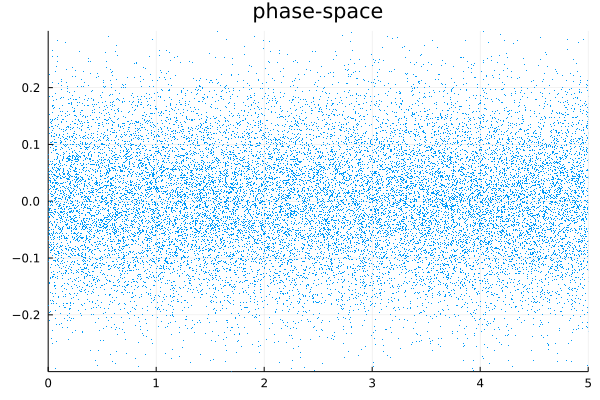

In [208]:
anim = @animate for i = 1:M_g
    scatter(par[i,1:N], par[i,N+1:2N]
    , markersize = 0.3
    , title = "phase-space"
    , legend=false
    , ylim = (-0.3,0.3)
    , xlim = (0,5)
    )
end
 
gif(anim, "run_name * ps_fps5.gif", fps = 5)